In [43]:
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import sqlite3
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import sys
from tqdm import tqdm
import warnings

# Suppression warnings KMeans
warnings.filterwarnings(action='ignore', 
                        message='KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.')
# Liste des fonctions

def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)
        
def f_clusters_transform (df):
    """
    df : dataframe pandas
    """
    data = df.values.T
    names = df.columns
    return(data, names)



def f_clusters_coude (df, k_max:int=15):
    """
    k_max : entier représentant le nombre max de clusters à tracer
    """
    
    data, names = f_clusters_transform(df)

    results = pd.DataFrame(columns=["Sum_of_squared_distances","gain"], index=np.arange(1,61))

    K = np.arange(1,k_max)
    for k in tqdm (K,  
               desc="Calcul de l'inertie",  
               ascii=False, ncols=100) : 
        km = KMeans(n_clusters=k, n_init=1000, max_iter=2000) 
        km = km.fit(data) 
        results.loc[k,"Sum_of_squared_distances"] = km.inertia_


    K_seuil = np.arange(25,61)
    for k in tqdm (K_seuil,  
               desc="Calcul du seuil…",  
               ascii=False, ncols=100) : 
        km = KMeans(n_clusters=k, n_init=50, max_iter=500) 
        km = km.fit(data) 
        results.loc[k,"Sum_of_squared_distances"] = km.inertia_


    results["gain"] = -results["Sum_of_squared_distances"].diff(1)/results["Sum_of_squared_distances"]
    Q1 = np.quantile(results.loc[31:,"gain"].values,0.25)
    Q3 = np.quantile(results.loc[31:,"gain"].values,0.75)
    seuil = Q3 + 1.5 * (Q3-Q1)
    k_opt = results.loc[results["gain"]<seuil].index.min()-1


    # Affichage des graphs  
    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax.plot(K, results.iloc[:k_max-1,0], 'bx-')
    ax.plot(k_opt, results.iloc[k_opt-1,0], linestyle = 'none', marker = 'X', c = 'r', markersize=15)
    ax.set_xlabel("k")
    ax.set_ylabel('Sum_of_squared_distances') 
    ax.set_title('Méthode du coude pour k optimal') 
    ax.set_xticks(K)

    ax2.plot(results.gain)
    ax2.fill_between(np.arange(1,60), 0, seuil, color='lightcoral')
    ax2.axvline(k_opt,color='red')
    ax2.axhline(results.iloc[k_opt-1,1],color='red')
    ax2.set_xlabel('k') 
    ax2.set_ylabel('gain') 
    ax2.set_title('Evolution du gain avec k+1') 
    plt.show()

    print(f"Le nombre de clusters recommandé est de {k_opt}.")

 
    
    
def f_clusters_fit (df, k:int = 4, n_init:int = 100, max_iter:int = 2000):
    
    """
    Entrainement et affichage de la distribution dans les clusters
    return :
    - cluster_table : df bss - cluster - MSE
    - df_clusters_centers : df série temporelle des clusters
    - metric : "euclidean" / "dtw" / "softdtw"
    """
    
    data, names = f_clusters_transform(df)
    # Initilialisation du modèle
    km = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, random_state=2022)
    # Entraînement du modèle
    km.fit(data)
    # Définition des numéros de cluster
    labels = km.labels_+1 
    # Profils des clusters
    cluster_centers = np.array(km.cluster_centers_)
    df_cluster_centers = pd.DataFrame(cluster_centers.T, index=df.index)
    for cluster in range(df_cluster_centers.shape[1]):
        df_cluster_centers.rename(columns = {cluster:f"cluster_{cluster+1}"}, inplace=True)
    
    # Création du dataframe de résultats
    cluster_table = pd.DataFrame()
    cluster_table["code_bss"] = names
    cluster_table.set_index("code_bss", inplace=True)
    cluster_table["cluster"] = labels
    for piezo in cluster_table.index :
        cluster_table.loc[piezo, "MSE"] = mean_squared_error(df.loc[:,piezo], cluster_centers[cluster_table.loc[piezo, "cluster"]-1])
    
    return cluster_table, df_cluster_centers

def f_plot_clusters (df, cluster_table, cluster_centers, plot_mean:bool = True):
    
    data, names = f_clusters_transform (df)
    
    labels = cluster_table["cluster"]
    
    fig, axs = plt.subplots(len(set(labels)),1,figsize=(20,4*cluster_centers.shape[1]))
    row_i=0

    for label in set(labels):
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i].plot(df.iloc[:,i],alpha=0.4)
        if plot_mean:
            axs[row_i].plot(cluster_centers.iloc[:,label-1],c="red")
        axs[row_i].set_title("Cluster "+str(row_i+1))
        row_i+=1
    plt.show()
    
def f_plot_all (df, cluster_table, df_cluster_centers) :

    if df.shape[1]%4 == 0:
        nbre_lignes = df.shape[1]//4
    else : 
        nbre_lignes = df.shape[1]//4 + 1

    fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
    #fig.suptitle('Series')
    for i in range(nbre_lignes):
        for j in range(4):
            if i*4+j+1>df.shape[1]: # pass the others that we can't fill
                continue
            axs[i, j].plot(df.iloc[:,i*4+j])
            axs[i, j].plot(df_cluster_centers.iloc[:,cluster_table.iloc[i*4+j,0]-1])
            
            axs[i, j].set_title(df.columns[i*4+j] + f" - MSE = {round(cluster_table.loc[df.columns[i*4+j],'MSE'],2)}")
            
    plt.show()
    
def f_MSEmax (cluster_table):
    # Calcul de MSEmin

    Q1 = cluster_table["MSE"].quantile(0.25, "higher")
    Q3 = cluster_table["MSE"].quantile(0.75, "lower")

    # Ecart inter-quartile
    IQM = abs(Q3-Q1)

    # Seuil minimal de conservation des chroniques (Q3+1.5*IQM)

    MSEmin = Q3+1.5*IQM
    return MSEmin

# Chargement des données

In [44]:
region = "NAQ"

In [45]:
# Import du csv et conversion en dataframe
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
data = pd.read_csv(f"./data/{region}.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

print(f"Il y a {data.shape[1]} piezos pour le clustering dans le dataframe.")

Il y a 424 piezos pour le clustering dans le dataframe.


## Analyse du nombre optimal de clusters

Calcul de l'inertie:   0%|                                                   | 0/14 [00:00<?, ?it/s]C:\Users\daranlot\Anaconda3\envs\Environnement\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
Calcul du seuil…: 100%|█████████████████████████████████████████████| 36/36 [00:26<00:00,  1.35it/s]


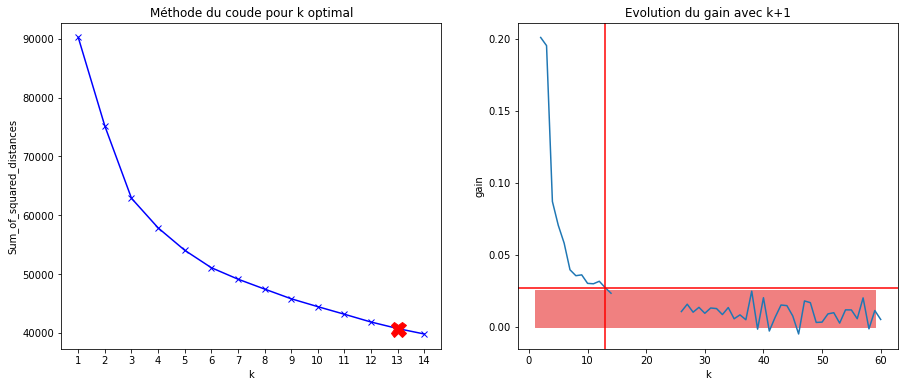

Le nombre de clusters recommandé est de 13.


In [46]:
coude = f_clusters_coude(data, 15)

## Création des clusters

In [47]:
# Choix du nombre de clusters à créer
nbre_clusters = 6

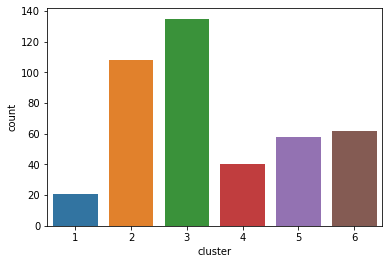

In [48]:
# Entrainement
cluster_table, cluster_centers = f_clusters_fit(data, nbre_clusters, n_init = 2000, max_iter = 5000)

# répartition des piezos dans les clusters
sns.countplot(data = cluster_table, x = "cluster")
# On renomme les noms de cluster par rapport à la région
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{region}_{index+1}"}, inplace=True)

## Affichage des clusters

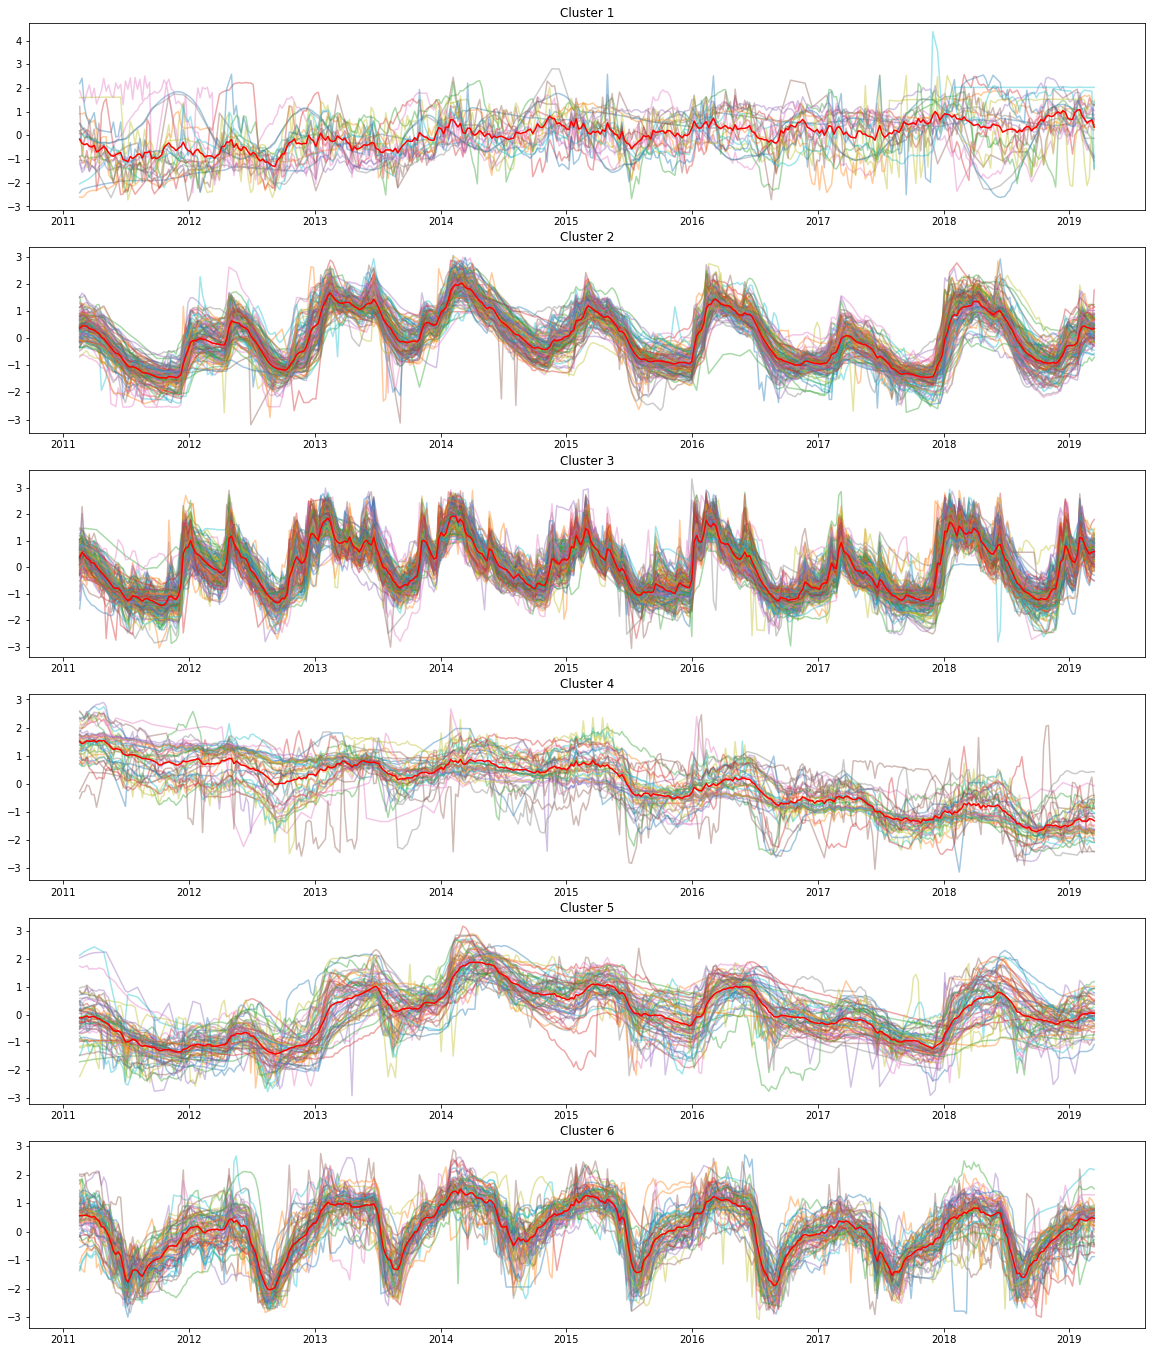

,MSE
cluster,
1,0.740080
2,0.222909
3,0.220572
4,0.332841
5,0.339551
6,0.300264


In [49]:
f_plot_clusters(data, cluster_table, cluster_centers)
cluster_table.groupby("cluster").mean()

In [50]:
#f_plot_all(data, cluster_table, cluster_centers)

## Filtre des chroniques avec score insuffisant

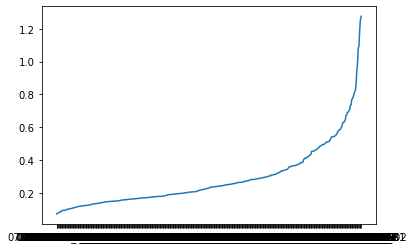

In [51]:
plt.plot(cluster_table["MSE"].sort_values())

Itération 0 : 27 chronique(s) éliminée(s).
Itération 0 : 19 chronique(s) éliminée(s).
Itération 1 : 14 chronique(s) éliminée(s).
Itération 2 : 1 chronique(s) éliminée(s).
Itération 3 : 1 chronique(s) éliminée(s).
Itération 4 : 1 chronique(s) éliminée(s).
Itération 5 : 0 chronique(s) éliminée(s).
Nombre total de chroniques éliminées : 63


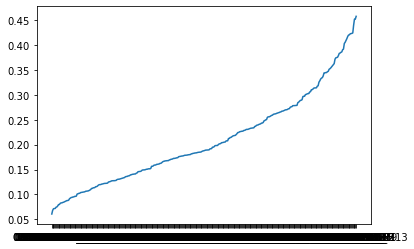

In [52]:
# nbre de chroniques sous le seuil
MSEmax = f_MSEmax(cluster_table)
cluster_table.loc[cluster_table.MSE > MSEmax, "cluster"] = 0

nbre_elim_total = 0
nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmax, 'MSE'].count()
nbre_elim_total += nbre_elim

iteration = 0
print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")

while nbre_elim != 0 :
    
    # Selection des clusters non zéro
    data_opt = data.copy().loc[:,cluster_table.loc[cluster_table.cluster != 0].index]
    
    # Nouveau clustering
    cluster_table, cluster_centers = f_clusters_fit(data_opt, nbre_clusters, n_init = 100, max_iter = 2000)

    # chroniques sous le seuil passées à cluster 0
    MSEmax = f_MSEmax(cluster_table)
    nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmax, 'MSE'].count()   
    nbre_elim_total += nbre_elim
    

    cluster_table.loc[cluster_table.MSE > MSEmax, "cluster"] = 0

    print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")
    iteration += 1
    
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{region}_{index+1}"}, inplace=True)    
    
print(f"Nombre total de chroniques éliminées : {nbre_elim_total}")
    
plt.plot(cluster_table["MSE"].sort_values())

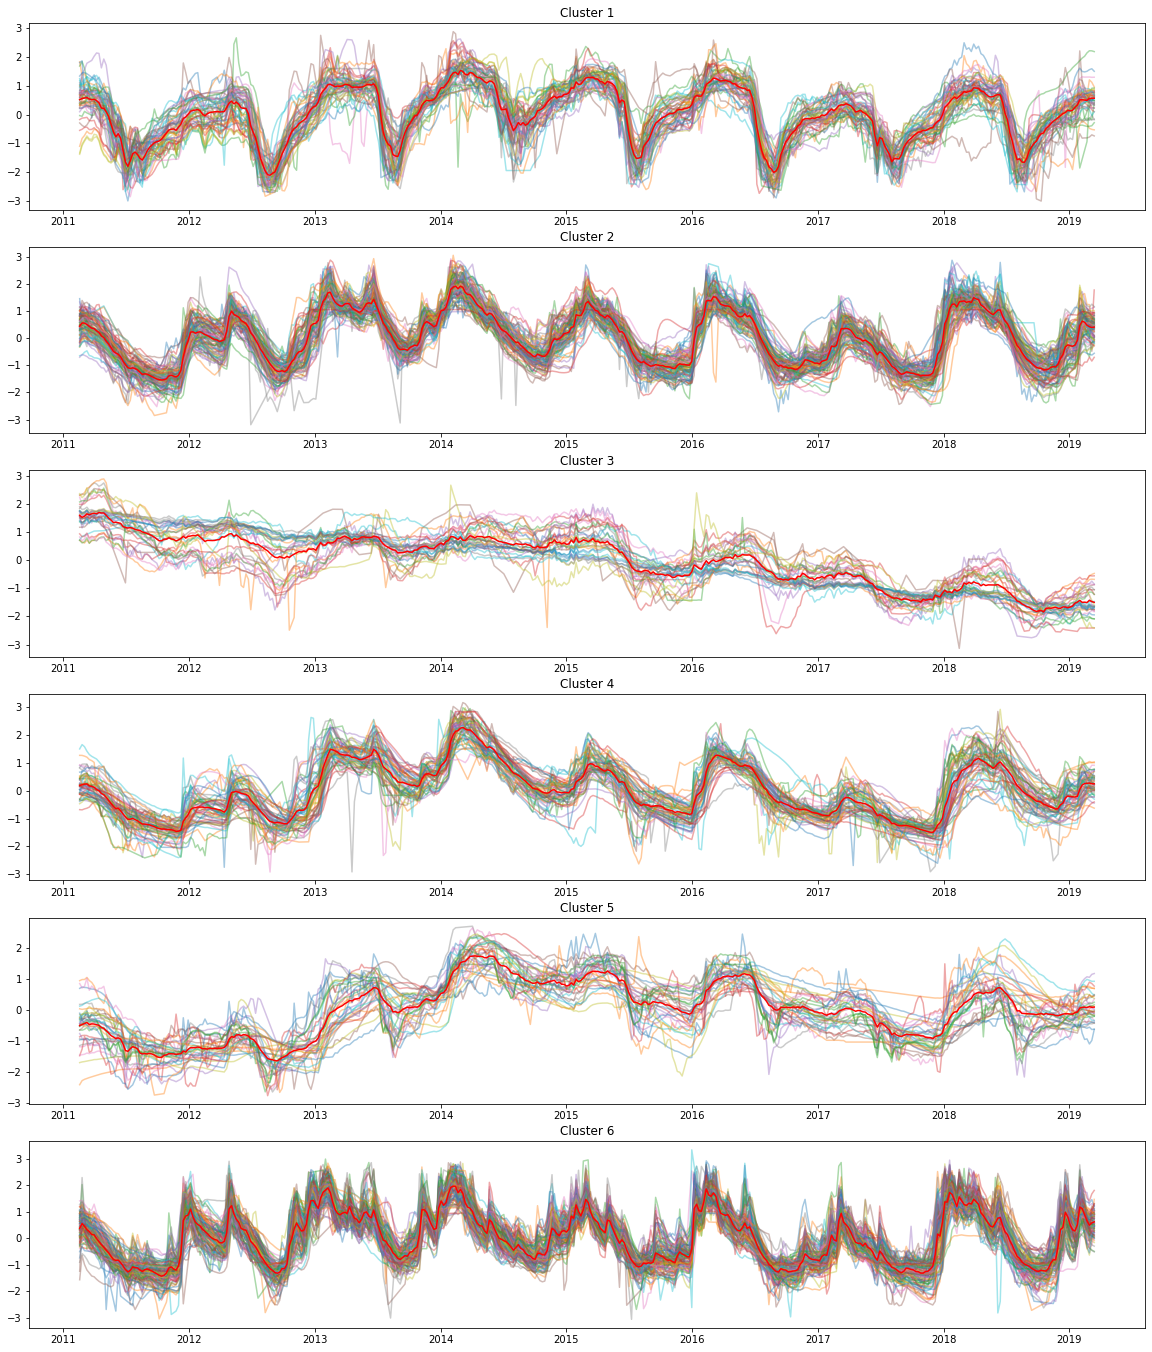

In [53]:
f_plot_clusters(data_opt, cluster_table, cluster_centers)

<AxesSubplot:xlabel='cluster', ylabel='count'>

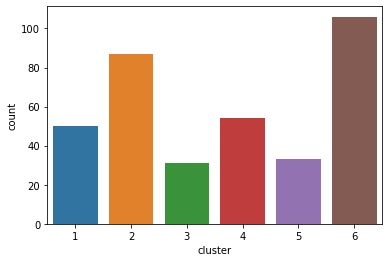

In [54]:
sns.countplot(data = cluster_table, x = "cluster")

In [55]:
cluster_table.groupby("cluster").mean()

,MSE
cluster,
1,0.236812
2,0.178571
3,0.222830
4,0.219270
5,0.257289
6,0.193776


## Sous-clusters

6    106
2     87
4     54
1     50
5     33
3     31
Name: cluster, dtype: int64

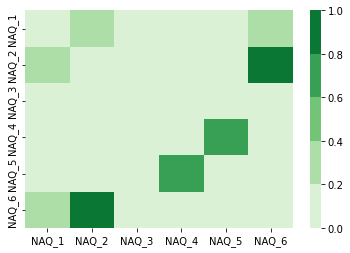

In [56]:
scoring = pd.DataFrame(columns=cluster_centers.columns, index=cluster_centers.columns)
scoring = scoring.fillna(0)

# Itération du clustering en fonction de nbre_clusters
for iteration in range (2, nbre_clusters) :
    cluster_table_2, cluster_centers_2 = f_clusters_fit(cluster_centers, iteration)
    for line in cluster_table_2.index:
        for colonne in cluster_table_2.index:
            if line == colonne :
                pass
            elif cluster_table_2.cluster[line] == cluster_table_2.cluster[colonne]:
                scoring.loc[line, colonne] += ((iteration-1))
                
# Il y a nbre_clusters -3 itérations.
# Le score max est donc la suite 1+2+...+(nbre_clusters-2) = (nbre_clusters-2)*(nbre_clusters-2+1)/2)
scoring_pourc = round(scoring / ((nbre_clusters-2)*(nbre_clusters-1)/2),2)
sns.heatmap(scoring_pourc, cmap = sns.color_palette("Greens",5))
cluster_table.cluster.value_counts()

### Création des listes de sous-clusters

In [57]:
# Sous clusterisation

liste_liste = []
list_inList = []

for line in cluster_table.cluster.value_counts().index:
    liste = []
    if line in list_inList :
        pass
    else :
        list_inList.append(line)
        liste.append(line)
        
        for colonne in cluster_table.cluster.value_counts().index:
            if scoring_pourc.loc[f"{region}_{line}", f"{region}_{colonne}"] > 0.4 :
                liste.append(colonne)
                list_inList.append(colonne)
        liste_liste.append(liste)
liste_liste

[[6, 2], [4, 5], [1], [3]]

### Modification des libellés

In [58]:
# Pour incrémentation littéraire
ch = "A"

liste_liste_2 = liste_liste.copy()

for index_sous_cluster, sous_cluster in enumerate (liste_liste):
    for index_cluster, cluster in enumerate (sous_cluster) :
        if len(sous_cluster) > 1:
            liste_liste_2[index_sous_cluster][index_cluster] = chr(ord(ch)+index_sous_cluster) + str(index_cluster+1)
        else :
            liste_liste_2[index_sous_cluster][index_cluster] = chr(ord(ch)+index_sous_cluster)

liste_liste_2_flat = []            
for index_sous_cluster in liste_liste_2 :
    liste_liste_2_flat += index_sous_cluster
    
    
# Liste des clusters d'ogine
liste_clusters = list(cluster_table.cluster.value_counts().index)
    
# Renommage    
cluster_table.replace(liste_clusters, liste_liste_2_flat, inplace=True)    

# Enregistrement des profils des clusters

# Ajout à la bdd

In [59]:
# Nom de la table
table = "cluster_kmeans"

In [60]:
# Création de la table
requete = f"""
                    ALTER TABLE data_piezo
                    ADD {table} VARCHAR(6) DEFAULT NULL
                    """
f_requete_sql(requete)

Connexion réussie à SQLite
Erreur lors du mis à jour dans la table duplicate column name: cluster_kmeans


In [61]:
# Création de listes de nuéro de cluster avec le nom des piezos
# Ajout dans la bdd
for label in set(cluster_table.cluster):
    cluster = tuple(cluster_table.loc[cluster_table.cluster == label, 'cluster'].index.to_list())
    requete = f"""
        UPDATE data_piezo
        SET {table} = '{region}_{label}'
        WHERE code_bss IN {cluster}
        """
    f_requete_sql(requete)

Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée


## Suppresion colonne

requete = """
                    ALTER TABLE data_piezo
                    DROP cluster_kmeans
                    """
f_requete_sql(requete)